## Homework 02-2: due 2024/04/08 23:59 (70%)

### - Tutorial : https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a regression model in this part. The data is **Concrete Compressive Strength Dataset**, you can find the details of each column at https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength. In this part, please predict the **strength of concrete**.

In [18]:
# Import necessory modules
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [19]:
# For reproduce the result
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### 1. Define the model and dataset (10%)

#### 1.1 Please follow the Step 2 from the tutorial to create a class ***ConcreteDataset*** to load the data you need and also do the ***Min-Max scaling*** to the ***feature and label***. (5%)

In [21]:
class Min_Max_Scaler:
    def __init__(self):
        None

    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)

    def transform(self, data):
        scaling_data = data.copy()
        for i in range(data.shape[1]):
            scaling_data[:, i] = 2 * ((data[:, i] - self.min[i]) / (self.max[i] - self.min[i])) - 1
        return scaling_data
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def y_inverse_transform(self, scaling_y):
        return (scaling_y + 1) * (self.max[-1] - self.min[-1]) / 2 + self.min[-1]

In [22]:
class ConcreteDataset(Dataset):
   def __init__(self, data):
      self.X = torch.tensor(data[:, :-1]).to(torch.float32)
      self.y = torch.tensor(data[:, -1]).to(torch.float32)
    
   def __len__(self):
      return len(self.X)
    
   def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

#### 1.2 By following the tutorial, try to create a class ***MLP(Neural Network)*** with ***three hidden layers*** as your network architecture. Also, for the convenience of implementation, please set the numbers of hidden nodes and the activation functions as input variables to the foward functions.(5%) 

In [23]:
class MLP_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 256),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 8),
            nn.Tanh(),
            nn.Linear(8, 1),
            nn.Tanh(),
        )
        
    def forward(self, X):
        outputs = self.net(X)
        return outputs

In [24]:
class MLP_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, 8),
            nn.Tanh(),
            nn.Linear(8, 1),
        )
        
    def forward(self, X):
        outputs = self.net(X)
        return outputs

### 2. Train the model (60%)

#### 2.1 Please load the ***train.csv/ validation.csv*** in ./data, and turn them into dataloader with batch size 64 and determine whether shuffle or not. (5%)

In [25]:
train_data = np.array(pd.read_csv("./data/train.csv"))
test_data = np.array(pd.read_csv("./data/test.csv"))
valid_data = np.array(pd.read_csv("./data/validation.csv"))

scaler = Min_Max_Scaler()

train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)
valid_data_scaled = scaler.transform(valid_data)

train_data_loader = DataLoader(ConcreteDataset(train_data_scaled), batch_size=64, shuffle=True)
test_data_loader = DataLoader(ConcreteDataset(test_data_scaled))
valid_data_loader = DataLoader(ConcreteDataset(valid_data_scaled), batch_size=64, shuffle=True)

#### 2.2 Create two MLP model from the table below and ***print the model*** (10%):
| | Hidden Layer 1| Hidden Layer 2| Hidden Layer 3| Activation in each hidden nodes | Activation for output |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Model1***| 256 | 64 | 8 | Tanh | Tanh |
|***Model1***| 64 | 16 | 8 | Tanh | Identity |

In [26]:
model_1 = MLP_1().to(device)
model_2 = MLP_2().to(device)
print("Model 1:\n", model_1, "\n\nModel 1:\n", model_2)

Model 1:
 MLP_1(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Tanh()
  )
) 

Model 1:
 MLP_2(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)


#### 2.3 Train the above two models with the same hyperpameters below and do the validation in every epoch. Choose the appropriate type of loss function according to the task. (25%)
##### (Note. You should record the training/validation loss every epoch)


| | Learning rate | epochs | optimizer | momentum |
|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 0.01 | 300 | SGD | 0.9 |

In [27]:
loss_fn = nn.MSELoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

In [28]:
def train(dataloader, model, loss_fn, optimizer):
    epoch_loss = 0.
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss /= len(dataloader)
    return epoch_loss

def valid(dataloader, model, loss_fn):
    epoch_loss = 0.
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y.unsqueeze(1))
            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
    return epoch_loss

In [29]:
epochs = 300
loop = tqdm(range(epochs))
train_loss_1, valid_loss_1, train_loss_2, valid_loss_2 = np.array([]), np.array([]), np.array([]), np.array([])
for i in loop:
    train_loss_1 = np.append(train_loss_1, train(train_data_loader, model_1, loss_fn, optimizer_1))
    valid_loss_1 = np.append(valid_loss_1, valid(valid_data_loader, model_1, loss_fn))
    train_loss_2 = np.append(train_loss_2, train(train_data_loader, model_2, loss_fn, optimizer_2))
    valid_loss_2 = np.append(valid_loss_2, valid(valid_data_loader, model_2, loss_fn))
    loop.set_description(f"Epoch {i+1}/{epochs}")
    loop.set_postfix(model_1_train_loss=f"{train_loss_1[-1]:.6f}", model_1_valid_loss=f"{valid_loss_1[-1]:.6f}", model_2_train_loss=f"{train_loss_2[-1]:.6f}", model_2_valid_loss=f"{valid_loss_2[-1]:.6f}")

Epoch 300/300: 100%|██████████| 300/300 [00:13<00:00, 22.82it/s, model_1_train_loss=0.026363, model_1_valid_loss=0.062840, model_2_train_loss=0.029884, model_2_valid_loss=0.060739]


#### 2.4 Please include the plot that shows how the training/validation loss vary with the training epoch. Show the plots using the above two models and write down the observation. (5%)

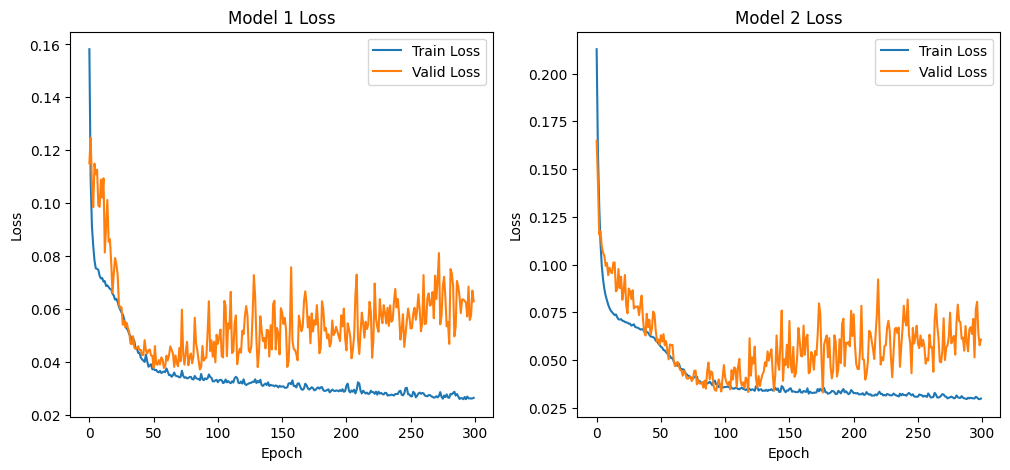

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Model 1 Loss")
ax[0].plot(train_loss_1, label="Train Loss")
ax[0].plot(valid_loss_1, label="Valid Loss")
ax[1].set_title("Model 2 Loss")
ax[1].plot(train_loss_2, label="Train Loss")
ax[1].plot(valid_loss_2, label="Valid Loss")
for i in range(2):
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend()
plt.show()

#### 2.5 From the observation of the previous question, please determine an appropriate epoch and retrain the two models to avoid overfitting. Also, draw the loss plot of two models and save the last model as ***model1.pth*** and ***model2.pth***. (10%)
##### (Note. You should reload the models and the optimizer, otherwise, you will resume from the previous stop.)

Model 2 Epoch 75/300: 100%|██████████| 75/75 [00:03<00:00, 23.31it/s, model_2_train_loss=0.038791, model_2_valid_loss=0.041928]


Saved PyTorch Model State to "model1.pth", and "model2.pth"


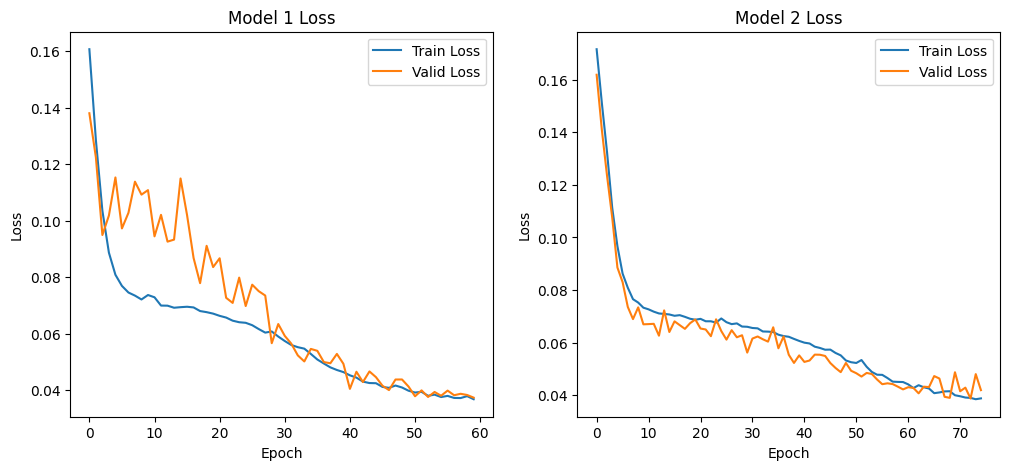

In [31]:
epochs1 = 60
epochs2 = 75
loop1 = tqdm(range(epochs1))
loop2 = tqdm(range(epochs2))

model_1 = MLP_1().to(device)
model_2 = MLP_2().to(device)
loss_fn = nn.MSELoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)
train_loss_1, valid_loss_1, train_loss_2, valid_loss_2 = np.array([]), np.array([]), np.array([]), np.array([])

for i in loop1:
    train_loss_1 = np.append(train_loss_1, train(train_data_loader, model_1, loss_fn, optimizer_1))
    valid_loss_1 = np.append(valid_loss_1, valid(valid_data_loader, model_1, loss_fn))
    loop1.set_description(f"Model 1 Epoch {i+1}/{epochs}")
    loop1.set_postfix(model_1_train_loss=f"{train_loss_1[-1]:.6f}", model_1_valid_loss=f"{valid_loss_1[-1]:.6f}")

for i in loop2:
    train_loss_2 = np.append(train_loss_2, train(train_data_loader, model_2, loss_fn, optimizer_2))
    valid_loss_2 = np.append(valid_loss_2, valid(valid_data_loader, model_2, loss_fn))
    loop2.set_description(f"Model 2 Epoch {i+1}/{epochs}")
    loop2.set_postfix(model_2_train_loss=f"{train_loss_2[-1]:.6f}", model_2_valid_loss=f"{valid_loss_2[-1]:.6f}")

torch.save(model_1.state_dict(), "model1.pth")
torch.save(model_2.state_dict(), "model2.pth")
print("Saved PyTorch Model State to \"model1.pth\", and \"model2.pth\"")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Model 1 Loss")
ax[0].plot(train_loss_1, label="Train Loss")
ax[0].plot(valid_loss_1, label="Valid Loss")
ax[1].set_title("Model 2 Loss")
ax[1].plot(train_loss_2, label="Train Loss")
ax[1].plot(valid_loss_2, label="Valid Loss")
for i in range(2):
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend()
plt.show()

#### 2.6 Please load the checkpoints saved from previous question and calculate the mean squared error on test dataset for two models respectively. Also, make a dataframe with target and prediction like below and save it as ***regression.csv*** (5%)
|Target|Model1|Model2|
|:---:|:---:|:---:|
|24.05|26.35|27.04|
|21.67|32.78|21.95|

In [32]:
def test(dataloader, model, loss_fn):
    model.eval()
    pred_all = np.array([])
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
            pred_all = np.append(pred_all, pred.cpu().numpy())
    test_loss /= len(dataloader)
    return test_loss, pred_all

In [33]:
model_1.load_state_dict(torch.load("model1.pth"))
model_2.load_state_dict(torch.load("model2.pth"))
model_1.eval()
model_2.eval()

test1_loss, pred1 = test(test_data_loader, model_1, loss_fn)
test2_loss, pred2 = test(test_data_loader, model_2, loss_fn)
print(f"Test 1 average loss: {test1_loss:>8f}\nTest 2 average loss: {test2_loss:>8f}")

pred1 = scaler.y_inverse_transform(pred1)
pred2 = scaler.y_inverse_transform(pred2)

regression_result = pd.DataFrame({"Target":test_data[:, -1], "Model1": pred1, "Model2": pred2})
regression_result

Test 1 average loss: 0.032117
Test 2 average loss: 0.032354


,Target,Model1,Model2
0,26.06,36.968701,34.688690
1,10.35,15.613440,9.341841
2,74.99,56.975096,54.572150
3,59.00,53.578528,47.857256
4,52.12,42.784206,42.051085
...,...,...,...
98,33.40,37.497534,33.374781
99,39.27,38.806921,34.188080
100,18.13,20.937054,17.704983
101,33.01,25.592991,21.787976


In [34]:
regression_result.to_csv("regression.csv", index=False)
print("Saved regression result to \"regression.csv\"")

Saved regression result to "regression.csv"
